In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib
import os
import sys
import json
sys.path.append('../')
from utils import utils
from collections import defaultdict
from utils import mpl_stylesheet

mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt')

In [6]:
empirical_percents = [5, 1, 0.05]
sbs = ["0.01", "0.05"]
methods = ["tejaas_perm", "matrixeqtl"]
data_dir = "/cbscratch/franco/trans-eqtl/analysis/data"

tissue_file = "../plots/tissues.txt"
tissues, descriptions = utils.read_tissues(tissue_file)

json_file = "../gtex_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
my_colors = []
for d in descriptions:
    my_colors.append("#"+gtex_meta[d.replace(" ", "_")]["colorHex"])

In [7]:
def load_plot_data(auc_file, N, tissue_dict):
    auc_array = np.zeros((N,N)) # + 0.5
    if os.path.exists(auc_file):
        with open(auc_file) as instream:
            for line in instream:
                t1  = line.split("\t")[0]
                t2  = line.split("\t")[1]
                auc = np.float64(line.split("\t")[2])
                auc1k = np.float64(line.split("\t")[3].rstrip())
                i = tissue_dict.get(t1, None)
                j = tissue_dict.get(t2, None)
                if i is None:
                    print("Oops, {:s} is not in the data".format(t1))
                    continue
                if j is None:
                    print("Oops, {:s} is not in the data".format(t2))
                    continue
                if i > j:
                    i,j = j,i
                auc_array[i,j] = auc
            #auc_dict[method] = auc_array
            # auc_dict[mkey] = auc_array
    else:
        print("File not found", auc_file)
    return auc_array

In [8]:
datasets = ["gtex-"+t for t in tissues]
print("Working with:", datasets)
ntissue = len(datasets)
matrix_dict = dict(zip(datasets, np.arange(ntissue)))

auc_dict = dict()
for ep in empirical_percents:
    for method in methods:
        if method == "tejaas_perm":
            for sb in sbs:
                method_sb = method + "_" + sb
                mkey = method_sb + "_ep" + str(ep)
                auc_dir = os.path.join(data_dir, method_sb, str(ep))
                auc_file = os.path.join(auc_dir, method_sb+".auc.txt")
                #print(auc_file)
                auc_array = load_plot_data(auc_file, ntissue, matrix_dict)
                auc_dict[mkey] = auc_array
        else:
            mkey = method + "_ep" + str(ep)
            auc_dir = os.path.join(data_dir, method, str(ep))
            auc_file = os.path.join(auc_dir, method+".auc.txt")    
            #print(auc_file)
            auc_array = load_plot_data(auc_file, ntissue, matrix_dict)
            auc_dict[mkey] = auc_array

mykeys = list(auc_dict.keys())
print("Loaded:", mykeys)

Working with: ['gtex-ban', 'gtex-bca', 'gtex-bceh', 'gtex-bce', 'gtex-bco', 'gtex-bfr', 'gtex-bhi', 'gtex-bhy', 'gtex-bnu', 'gtex-bpu', 'gtex-pit', 'gtex-pro', 'gtex-si', 'gtex-spl', 'gtex-ut', 'gtex-va', 'gtex-ag', 'gtex-liv', 'gtex-tes', 'gtex-ov', 'gtex-fib', 'gtex-ms', 'gtex-haa', 'gtex-hlv', 'gtex-pan', 'gtex-wb', 'gtex-snse', 'gtex-sse', 'gtex-colt', 'gtex-cols', 'gtex-esog', 'gtex-esom', 'gtex-esomu', 'gtex-thy', 'gtex-ac', 'gtex-aa', 'gtex-at', 'gtex-sto', 'gtex-lu', 'gtex-av', 'gtex-as', 'gtex-br']
Loaded: ['tejaas_perm_0.01_ep5', 'tejaas_perm_0.05_ep5', 'matrixeqtl_ep5', 'tejaas_perm_0.01_ep1', 'tejaas_perm_0.05_ep1', 'matrixeqtl_ep1', 'tejaas_perm_0.01_ep0.05', 'tejaas_perm_0.05_ep0.05', 'matrixeqtl_ep0.05']


In [9]:
from mpl_toolkits import axes_grid1
from matplotlib.colors import LinearSegmentedColormap

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1.0/aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring clipping and other edge cases here
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        result, is_scalar = self.process_value(value)
        #return np.ma.masked_array(np.interp(value, x, y))
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)
    
class LevelNormalize(matplotlib.colors.Normalize):
    def __init__(self, levels=None, clip=False):
        self.levels = levels
        self.vmin = self.levels.min()
        self.vmax = self.levels.max()
        matplotlib.colors.Normalize.__init__(self, self.vmin, self.vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring clipping and other edge cases here
        x = self.levels
        y = np.linspace(0, 1, len(x))
        #x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        result, is_scalar = self.process_value(value)
        #return np.ma.masked_array(np.interp(value, x, y))
        return np.ma.array(np.interp(value, x, y), mask=result.mask, copy=False)

In [12]:
lower = "matrixeqtl_ep0.05"
upper = "tejaas_perm_0.05_ep0.05"
method_array = auc_dict[lower].T + auc_dict[upper]
aucmin = np.min(method_array[np.where(method_array > 0)])
aucmax = max(np.max(auc_dict[lower]), np.max(auc_dict[upper]))
mask = np.diag(np.ones(ntissue))
triumask = np.triu(np.ones((ntissue, ntissue)))
mask = mask + triumask
masked_data = np.ma.masked_array(method_array, mask)

umedian = np.median(auc_dict[upper][np.where(auc_dict[upper] > 0)])
lmedian = np.median(auc_dict[lower][np.where(auc_dict[lower] > 0)])
datamean = np.mean(masked_data)
datastd  = np.std(masked_data)

levels = np.concatenate(([aucmin, aucmax], np.linspace(datamean - 2 * datastd, datamean + 2 * datastd, 100)))
levels = levels[levels <= aucmax]
levels.sort()

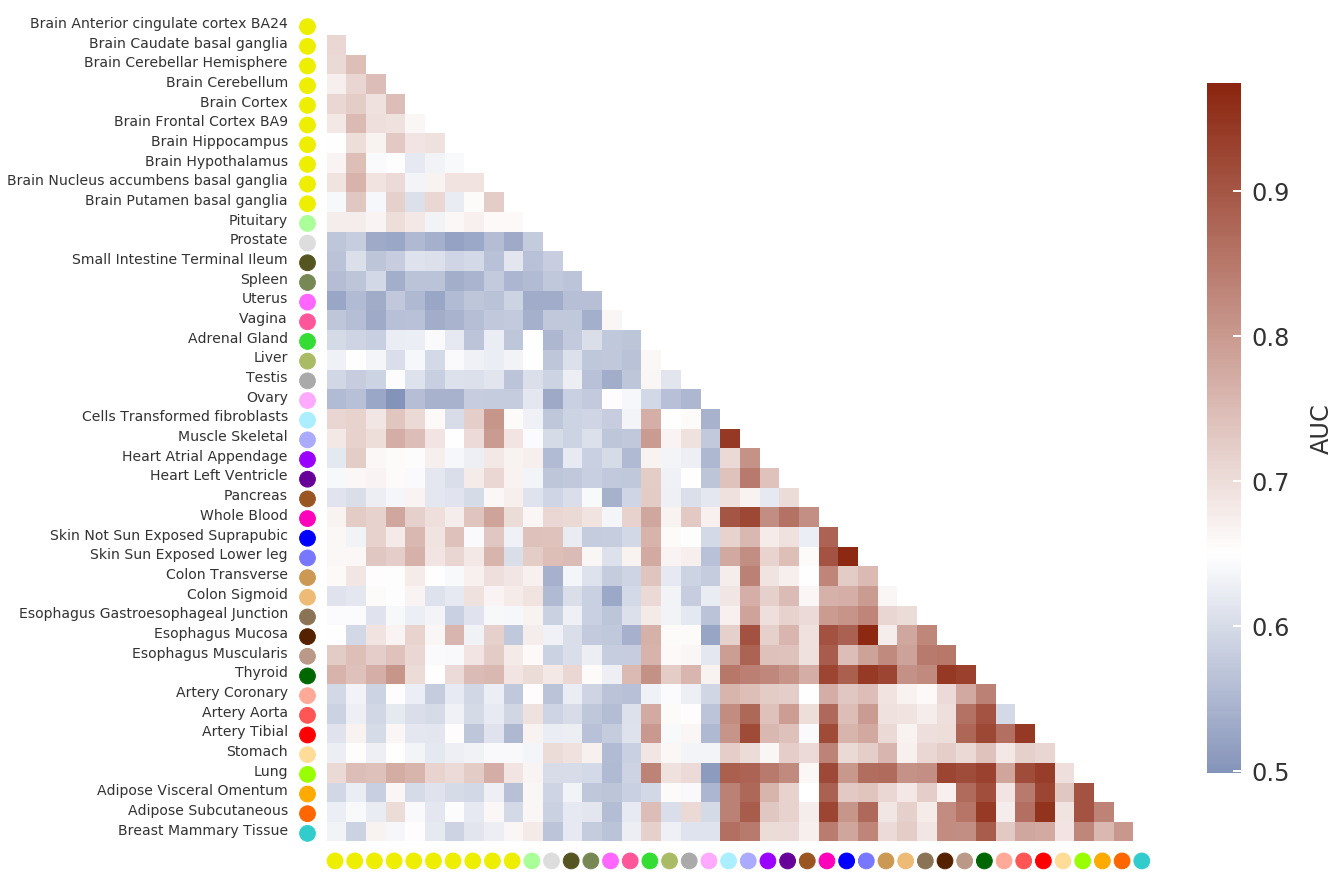

In [19]:
fig = plt.figure(figsize = (20, 12))
ax = fig.add_subplot(111, aspect = 'equal')
tickxpos = -1.0
tickypos = -1.0 #ntissue + 1.0
tickradius = 0.4
show_tissuenames = True

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('gtex_cmap', ['#8493B9', '#FFFFFF', '#8B250F'])
#cmap = matplotlib.cm.get_cmap('RdYlBu_r')
cmap.set_bad('w')
# norm = MidpointNormalize(midpoint = umedian, vmin = aucmin, vmax = aucmax)
norm = MidpointNormalize(midpoint = 0.65, vmin = aucmin, vmax = aucmax)
im = ax.pcolormesh(np.flipud(masked_data), norm = norm, cmap = cmap)

#cbar = add_colorbar(im)
cbar = ax.figure.colorbar(im, fraction=0.026, pad=0.04)
cbar.ax.tick_params(pad=10, color = 'w', direction = 'in', axis = 'both')
cbar.outline.set_linewidth(0)
cbar.ax.set_ylabel("AUC")
#cbar.outline.set_edgecolor(bordercolor)


# Remove all ticks and borders
ax.tick_params(bottom = False, top = False, left = False, right = False, 
               labelleft = False, labelbottom = False)
for side, border in ax.spines.items():
    border.set_visible(False)
    
# Show colors for the tissues
for i, d in enumerate(descriptions):
    ax.add_patch(matplotlib.patches.Circle((tickxpos, ntissue - i - 1 + tickradius), 
                                            radius = tickradius, color = my_colors[i], fill=True, clip_on=False))
    ax.add_patch(matplotlib.patches.Circle((i + tickradius, tickypos), 
                                            radius = tickradius, color = my_colors[i], fill=True, clip_on=False))
    
# Show names for the tissues (required for presentations)
if show_tissuenames:
    font_properties = {'size': 14, 'color': '#333333'}
else:
    font_properties = {'size': 14, 'color': '#FFFFFF'}
for i, d in enumerate(descriptions):
    ax.text(tickxpos - 1.0, ntissue - i - 1 + tickradius / 2, d, horizontalalignment='right', verticalalignment='bottom', **font_properties)
    
# ax.set_title("Tissue-Tissue validation AUC", fontsize=14)
fig.tight_layout()
#plt.savefig(, bbox_inches='tight')
plt.savefig('../plots/gtex_rr_05_meqtl_ep0.05.png', bbox_inches='tight')
plt.show()

In [ ]:
descriptions

In [ ]:
lmedian

In [ ]:
datamean

In [ ]:
datastd

In [ ]:
np.ma.masked_array(np.interp(masked_data, x, y), mask = masked_data.mask)

In [ ]:
len(np.arange(0, 100, 10))